# Method 2 - Best Ideas High Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] > popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

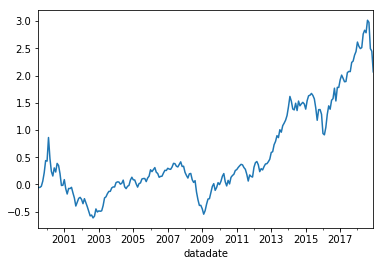

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.438518
2000-12-31   -0.314664
2001-12-31   -0.225392
2002-12-31   -0.351172
2003-12-31    0.926774
2004-12-31    0.186723
2005-12-31    0.018374
2006-12-31    0.089825
2007-12-31    0.062213
2008-12-31   -0.537584
2009-12-31    0.673685
2010-12-31    0.215761
2011-12-31   -0.095826
2012-12-31    0.289067
2013-12-31    0.547028
2014-12-31    0.093416
2015-12-31   -0.075839
2016-12-31    0.214519
2017-12-31    0.237049
2018-12-31   -0.108423
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     366.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.35e-98
Time:                        23:47:33   Log-Likelihood:                 486.73
No. Observations:                 234   AIC:                            -963.5
Df Residuals:                     229   BIC:                            -946.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.002      2.608      0.010       0.001       0.010
mktrf          1.0447      0.057     18.331      0.000       0.932       1.157
me             0.6022      0.066      9.085      0.000       0.472       0.733
ia            -0.2451      0.101     -2.432      0.016      -0.444      -0.047
roe           -0.9098      0.086    -10.549      0.000      -1.080      -0.740
==============================================================================
Omnibus:                       45.777   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.132
Skew:                           0.757   Prob(JB):                     1.69e-35
Kurtosis:                       6.759   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     246.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.20e-81
Time:                        23:47:33   Log-Likelihood:                 486.73
No. Observations:                 234   AIC:                            -963.5
Df Residuals:                     229   BIC:                            -946.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.002      2.233      0.026       0.001       0.010
mktrf          1.0447      0.062     16.739      0.000       0.922       1.167
me             0.6022      0.118      5.112      0.000       0.371       0.833
ia            -0.2451      0.168     -1.461      0.144      -0.574       0.084
roe           -0.9098      0.174     -5.220      0.000      -1.251      -0.568
==============================================================================
Omnibus:                       45.777   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.132
Skew:                           0.757   Prob(JB):                     1.69e-35
Kurtosis:                       6.759   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     334.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.61e-94
Time:                        23:47:33   Log-Likelihood:                 486.73
No. Observations:                 234   AIC:                            -963.5
Df Residuals:                     229   BIC:                            -946.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.002      2.286      0.022       0.001       0.010
mktrf          1.0447      0.049     21.509      0.000       0.950       1.140
me             0.6022      0.122      4.921      0.000       0.362       0.842
ia            -0.2451      0.136     -1.799      0.072      -0.512       0.022
roe           -0.9098      0.182     -4.996      0.000      -1.267      -0.553
==============================================================================
Omnibus:                       45.777   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.132
Skew:                           0.757   Prob(JB):                     1.69e-35
Kurtosis:                       6.759   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     301.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.80e-98
Time:                        23:47:33   Log-Likelihood:                 490.01
No. Observations:                 234   AIC:                            -968.0
Df Residuals:                     228   BIC:                            -947.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.002      2.523      0.012       0.001       0.009
mktrf          1.1340      0.056     20.095      0.000       1.023       1.245
smb            0.5445      0.074      7.313      0.000       0.398       0.691
hml           -0.0656      0.088     -0.748      0.456      -0.239       0.107
rmw           -0.9655      0.099     -9.726      0.000      -1.161      -0.770
cma            0.1256      0.126      0.995      0.321      -0.123       0.374
==============================================================================
Omnibus:                       30.004   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.600
Skew:                           0.657   Prob(JB):                     1.88e-13
Kurtosis:                       5.069   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     206.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.91e-82
Time:                        23:47:33   Log-Likelihood:                 490.01
No. Observations:                 234   AIC:                            -968.0
Df Residuals:                     228   BIC:                            -947.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.002      2.590      0.010       0.001       0.009
mktrf          1.1340      0.059     19.248      0.000       1.019       1.249
smb            0.5445      0.065      8.376      0.000       0.417       0.672
hml           -0.0656      0.128     -0.513      0.608      -0.317       0.185
rmw           -0.9655      0.164     -5.902      0.000      -1.286      -0.645
cma            0.1256      0.184      0.681      0.496      -0.236       0.487
==============================================================================
Omnibus:                       30.004   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.600
Skew:                           0.657   Prob(JB):                     1.88e-13
Kurtosis:                       5.069   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     290.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.01e-96
Time:                        23:47:33   Log-Likelihood:                 490.01
No. Observations:                 234   AIC:                            -968.0
Df Residuals:                     228   BIC:                            -947.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.002      2.939      0.003       0.002       0.009
mktrf          1.1340      0.062     18.146      0.000       1.012       1.256
smb            0.5445      0.068      8.020      0.000       0.411       0.678
hml           -0.0656      0.098     -0.669      0.503      -0.258       0.127
rmw           -0.9655      0.162     -5.945      0.000      -1.284      -0.647
cma            0.1256      0.154      0.814      0.415      -0.177       0.428
==============================================================================
Omnibus:                       30.004   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.600
Skew:                           0.657   Prob(JB):                     1.88e-13
Kurtosis:                       5.069   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     269.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.21e-85
Time:                        23:47:33   Log-Likelihood:                 456.51
No. Observations:                 234   AIC:                            -903.0
Df Residuals:                     229   BIC:                            -885.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.678      0.498      -0.003       0.006
mktrf          1.2825      0.060     21.481      0.000       1.165       1.400
smb            0.9206      0.075     12.353      0.000       0.774       1.067
hml           -0.2165      0.074     -2.924      0.004      -0.362      -0.071
umd           -0.1881      0.049     -3.872      0.000      -0.284      -0.092
==============================================================================
Omnibus:                       50.509   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.755
Skew:                           0.843   Prob(JB):                     2.52e-39
Kurtosis:                       6.922   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     153.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.76e-63
Time:                        23:47:33   Log-Likelihood:                 456.51
No. Observations:                 234   AIC:                            -903.0
Df Residuals:                     229   BIC:                            -885.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.698      0.485      -0.003       0.006
mktrf          1.2825      0.068     18.989      0.000       1.150       1.415
smb            0.9206      0.132      6.973      0.000       0.662       1.179
hml           -0.2165      0.113     -1.910      0.056      -0.439       0.006
umd           -0.1881      0.093     -2.029      0.042      -0.370      -0.006
==============================================================================
Omnibus:                       50.509   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.755
Skew:                           0.843   Prob(JB):                     2.52e-39
Kurtosis:                       6.922   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     143.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.63e-61
Time:                        23:47:33   Log-Likelihood:                 456.51
No. Observations:                 234   AIC:                            -903.0
Df Residuals:                     229   BIC:                            -885.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.788      0.430      -0.002       0.005
mktrf          1.2825      0.067     19.114      0.000       1.151       1.414
smb            0.9206      0.117      7.853      0.000       0.691       1.150
hml           -0.2165      0.100     -2.167      0.030      -0.412      -0.021
umd           -0.1881      0.100     -1.880      0.060      -0.384       0.008
==============================================================================
Omnibus:                       50.509   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.755
Skew:                           0.843   Prob(JB):                     2.52e-39
Kurtosis:                       6.922   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     183.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.13e-49
Time:                        23:47:33   Log-Likelihood:                 228.01
No. Observations:                 120   AIC:                            -446.0
Df Residuals:                     115   BIC:                            -432.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.004      1.436      0.154      -0.002       0.012
mktrf          1.0628      0.095     11.155      0.000       0.874       1.252
me             0.6432      0.094      6.835      0.000       0.457       0.830
ia            -0.2460      0.147     -1.669      0.098      -0.538       0.046
roe           -0.8654      0.130     -6.635      0.000      -1.124      -0.607
==============================================================================
Omnibus:                       24.980   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.070
Skew:                           0.780   Prob(JB):                     9.04e-14
Kurtosis:                       6.095   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     119.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.19e-40
Time:                        23:47:33   Log-Likelihood:                 228.01
No. Observations:                 120   AIC:                            -446.0
Df Residuals:                     115   BIC:                            -432.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.004      1.144      0.253      -0.004       0.014
mktrf          1.0628      0.100     10.646      0.000       0.867       1.258
me             0.6432      0.153      4.202      0.000       0.343       0.943
ia            -0.2460      0.239     -1.029      0.303      -0.715       0.223
roe           -0.8654      0.248     -3.486      0.000      -1.352      -0.379
==============================================================================
Omnibus:                       24.980   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.070
Skew:                           0.780   Prob(JB):                     9.04e-14
Kurtosis:                       6.095   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     166.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.46e-47
Time:                        23:47:33   Log-Likelihood:                 228.01
No. Observations:                 120   AIC:                            -446.0
Df Residuals:                     115   BIC:                            -432.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.004      1.182      0.237      -0.003       0.013
mktrf          1.0628      0.076     13.907      0.000       0.913       1.213
me             0.6432      0.161      3.993      0.000       0.327       0.959
ia            -0.2460      0.206     -1.193      0.233      -0.650       0.158
roe           -0.8654      0.261     -3.318      0.001      -1.377      -0.354
==============================================================================
Omnibus:                       24.980   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.070
Skew:                           0.780   Prob(JB):                     9.04e-14
Kurtosis:                       6.095   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     170.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.37e-51
Time:                        23:47:33   Log-Likelihood:                 236.33
No. Observations:                 120   AIC:                            -460.7
Df Residuals:                     114   BIC:                            -443.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.003      2.126      0.036       0.000       0.014
mktrf          1.2020      0.094     12.767      0.000       1.016       1.389
smb            0.5596      0.107      5.248      0.000       0.348       0.771
hml           -0.1098      0.131     -0.841      0.402      -0.369       0.149
rmw           -0.9147      0.154     -5.936      0.000      -1.220      -0.609
cma            0.2230      0.169      1.321      0.189      -0.111       0.557
==============================================================================
Omnibus:                       13.460   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.993
Skew:                           0.603   Prob(JB):                     0.000124
Kurtosis:                       4.464   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     163.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.76e-50
Time:                        23:47:33   Log-Likelihood:                 236.33
No. Observations:                 120   AIC:                            -460.7
Df Residuals:                     114   BIC:                            -443.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.003      2.187      0.029       0.001       0.014
mktrf          1.2020      0.083     14.541      0.000       1.040       1.364
smb            0.5596      0.093      6.028      0.000       0.378       0.742
hml           -0.1098      0.165     -0.667      0.505      -0.432       0.213
rmw           -0.9147      0.224     -4.083      0.000      -1.354      -0.476
cma            0.2230      0.211      1.059      0.290      -0.190       0.636
==============================================================================
Omnibus:                       13.460   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.993
Skew:                           0.603   Prob(JB):                     0.000124
Kurtosis:                       4.464   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     345.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.12e-67
Time:                        23:47:33   Log-Likelihood:                 236.33
No. Observations:                 120   AIC:                            -460.7
Df Residuals:                     114   BIC:                            -443.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.003      2.413      0.016       0.001       0.013
mktrf          1.2020      0.076     15.753      0.000       1.052       1.352
smb            0.5596      0.097      5.799      0.000       0.370       0.749
hml           -0.1098      0.136     -0.809      0.418      -0.376       0.156
rmw           -0.9147      0.231     -3.968      0.000      -1.366      -0.463
cma            0.2230      0.161      1.383      0.167      -0.093       0.539
==============================================================================
Omnibus:                       13.460   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.993
Skew:                           0.603   Prob(JB):                     0.000124
Kurtosis:                       4.464   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     157.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.23e-45
Time:                        23:47:33   Log-Likelihood:                 220.06
No. Observations:                 120   AIC:                            -430.1
Df Residuals:                     115   BIC:                            -416.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.004      0.789      0.432      -0.004       0.010
mktrf          1.3839      0.090     15.429      0.000       1.206       1.562
smb            0.9379      0.102      9.184      0.000       0.736       1.140
hml           -0.2443      0.102     -2.388      0.019      -0.447      -0.042
umd           -0.1507      0.063     -2.389      0.019      -0.276      -0.026
==============================================================================
Omnibus:                       28.652   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.821
Skew:                           0.829   Prob(JB):                     1.04e-18
Kurtosis:                       6.717   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     142.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.26e-43
Time:                        23:47:33   Log-Likelihood:                 220.06
No. Observations:                 120   AIC:                            -430.1
Df Residuals:                     115   BIC:                            -416.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.004      0.805      0.421      -0.004       0.010
mktrf          1.3839      0.086     16.090      0.000       1.215       1.552
smb            0.9379      0.155      6.041      0.000       0.634       1.242
hml           -0.2443      0.131     -1.858      0.063      -0.502       0.013
umd           -0.1507      0.101     -1.493      0.136      -0.348       0.047
==============================================================================
Omnibus:                       28.652   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.821
Skew:                           0.829   Prob(JB):                     1.04e-18
Kurtosis:                       6.717   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     208.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.09e-51
Time:                        23:47:34   Log-Likelihood:                 220.06
No. Observations:                 120   AIC:                            -430.1
Df Residuals:                     115   BIC:                            -416.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.003      0.937      0.349      -0.003       0.009
mktrf          1.3839      0.071     19.534      0.000       1.245       1.523
smb            0.9379      0.139      6.732      0.000       0.665       1.211
hml           -0.2443      0.115     -2.127      0.033      -0.469      -0.019
umd           -0.1507      0.103     -1.459      0.144      -0.353       0.052
==============================================================================
Omnibus:                       28.652   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.821
Skew:                           0.829   Prob(JB):                     1.04e-18
Kurtosis:                       6.717   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     175.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.56e-46
Time:                        23:47:34   Log-Likelihood:                 273.09
No. Observations:                 114   AIC:                            -536.2
Df Residuals:                     109   BIC:                            -522.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.002      2.433      0.017       0.001       0.010
mktrf          1.0588      0.066     15.970      0.000       0.927       1.190
me             0.4776      0.102      4.666      0.000       0.275       0.681
ia            -0.2624      0.142     -1.848      0.067      -0.544       0.019
roe           -1.0175      0.125     -8.156      0.000      -1.265      -0.770
==============================================================================
Omnibus:                       14.373   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.151
Skew:                           0.662   Prob(JB):                     6.94e-05
Kurtosis:                       4.509   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     318.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.86e-59
Time:                        23:47:34   Log-Likelihood:                 273.09
No. Observations:                 114   AIC:                            -536.2
Df Residuals:                     109   BIC:                            -522.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.002      3.175      0.001       0.002       0.009
mktrf          1.0588      0.060     17.562      0.000       0.941       1.177
me             0.4776      0.056      8.513      0.000       0.368       0.588
ia            -0.2624      0.126     -2.086      0.037      -0.509      -0.016
roe           -1.0175      0.139     -7.313      0.000      -1.290      -0.745
==============================================================================
Omnibus:                       14.373   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.151
Skew:                           0.662   Prob(JB):                     6.94e-05
Kurtosis:                       4.509   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     529.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.03e-70
Time:                        23:47:34   Log-Likelihood:                 273.09
No. Observations:                 114   AIC:                            -536.2
Df Residuals:                     109   BIC:                            -522.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.002      3.289      0.001       0.002       0.009
mktrf          1.0588      0.049     21.390      0.000       0.962       1.156
me             0.4776      0.047     10.126      0.000       0.385       0.570
ia            -0.2624      0.120     -2.188      0.029      -0.497      -0.027
roe           -1.0175      0.116     -8.784      0.000      -1.245      -0.790
==============================================================================
Omnibus:                       14.373   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.151
Skew:                           0.662   Prob(JB):                     6.94e-05
Kurtosis:                       4.509   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     110.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.94e-41
Time:                        23:47:34   Log-Likelihood:                 261.73
No. Observations:                 114   AIC:                            -511.5
Df Residuals:                     108   BIC:                            -495.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.003      1.317      0.191      -0.002       0.008
mktrf          1.1056      0.070     15.755      0.000       0.967       1.245
smb            0.4956      0.114      4.351      0.000       0.270       0.721
hml           -0.0031      0.145     -0.021      0.983      -0.291       0.285
rmw           -1.0270      0.178     -5.773      0.000      -1.380      -0.674
cma           -0.1106      0.226     -0.490      0.625      -0.558       0.337
==============================================================================
Omnibus:                        4.429   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                4.010
Skew:                           0.327   Prob(JB):                        0.135
Kurtosis:                       3.646   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     86.56
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.70e-36
Time:                        23:47:34   Log-Likelihood:                 261.73
No. Observations:                 114   AIC:                            -511.5
Df Residuals:                     108   BIC:                            -495.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.436      0.151      -0.001       0.008
mktrf          1.1056      0.080     13.736      0.000       0.948       1.263
smb            0.4956      0.073      6.809      0.000       0.353       0.638
hml           -0.0031      0.161     -0.019      0.985      -0.319       0.313
rmw           -1.0270      0.266     -3.865      0.000      -1.548      -0.506
cma           -0.1106      0.195     -0.567      0.571      -0.493       0.272
==============================================================================
Omnibus:                        4.429   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                4.010
Skew:                           0.327   Prob(JB):                        0.135
Kurtosis:                       3.646   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     139.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.04e-45
Time:                        23:47:34   Log-Likelihood:                 261.73
No. Observations:                 114   AIC:                            -511.5
Df Residuals:                     108   BIC:                            -495.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.759      0.079      -0.000       0.007
mktrf          1.1056      0.081     13.637      0.000       0.947       1.265
smb            0.4956      0.067      7.411      0.000       0.365       0.627
hml           -0.0031      0.174     -0.018      0.986      -0.344       0.338
rmw           -1.0270      0.254     -4.046      0.000      -1.524      -0.530
cma           -0.1106      0.203     -0.545      0.586      -0.509       0.287
==============================================================================
Omnibus:                        4.429   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                4.010
Skew:                           0.327   Prob(JB):                        0.135
Kurtosis:                       3.646   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     104.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.71e-36
Time:                        23:47:34   Log-Likelihood:                 248.34
No. Observations:                 114   AIC:                            -486.7
Df Residuals:                     109   BIC:                            -473.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.672      0.503      -0.004       0.007
mktrf          1.1566      0.078     14.817      0.000       1.002       1.311
smb            0.7329      0.122      6.021      0.000       0.492       0.974
hml            0.0064      0.125      0.051      0.960      -0.242       0.255
umd           -0.2207      0.095     -2.334      0.021      -0.408      -0.033
==============================================================================
Omnibus:                       18.729   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.711
Skew:                           0.742   Prob(JB):                     2.14e-07
Kurtosis:                       5.065   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     100.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.47e-35
Time:                        23:47:34   Log-Likelihood:                 248.34
No. Observations:                 114   AIC:                            -486.7
Df Residuals:                     109   BIC:                            -473.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.873      0.383      -0.002       0.006
mktrf          1.1566      0.082     14.180      0.000       0.997       1.316
smb            0.7329      0.103      7.112      0.000       0.531       0.935
hml            0.0064      0.197      0.032      0.974      -0.380       0.393
umd           -0.2207      0.097     -2.287      0.022      -0.410      -0.032
==============================================================================
Omnibus:                       18.729   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.711
Skew:                           0.742   Prob(JB):                     2.14e-07
Kurtosis:                       5.065   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     110.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.28e-37
Time:                        23:47:34   Log-Likelihood:                 248.34
No. Observations:                 114   AIC:                            -486.7
Df Residuals:                     109   BIC:                            -473.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.950      0.342      -0.002       0.006
mktrf          1.1566      0.079     14.669      0.000       1.002       1.311
smb            0.7329      0.078      9.349      0.000       0.579       0.887
hml            0.0064      0.205      0.031      0.975      -0.396       0.408
umd           -0.2207      0.091     -2.425      0.015      -0.399      -0.042
==============================================================================
Omnibus:                       18.729   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.711
Skew:                           0.742   Prob(JB):                     2.14e-07
Kurtosis:                       5.065   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""